# Assignment 2 - February Group

In [88]:
# Install Packages
# install.packages("quanteda")
# install.packages("textclean")
# install.packages("ggrepel")
# install.packages("glmnet")
# install.packages("pROC")

# Run libraries
library(quanteda)
library(ggrepel)
library(textclean)
library(tidyverse)
library(glmnet)
library(pROC)

In [89]:
# Load in scripts

# n-gram converter
source("TMEF_dfm.R")

# Kendall accuracy
source("kendall_acc.R")

# Load in data
glassdoor<-readRDS("glassdoorReviews.RDS")

In [90]:
# List companies in the dataset
head(unique(glassdoor$company))

[1] "google"    "amazon"    "facebook"  "netflix"   "apple"     "microsoft"

In [91]:
overall_avgs <- glassdoor %>% 
    group_by(company) %>%
    summarize(m=mean(overall),
        se=sd(overall/sqrt(n())))

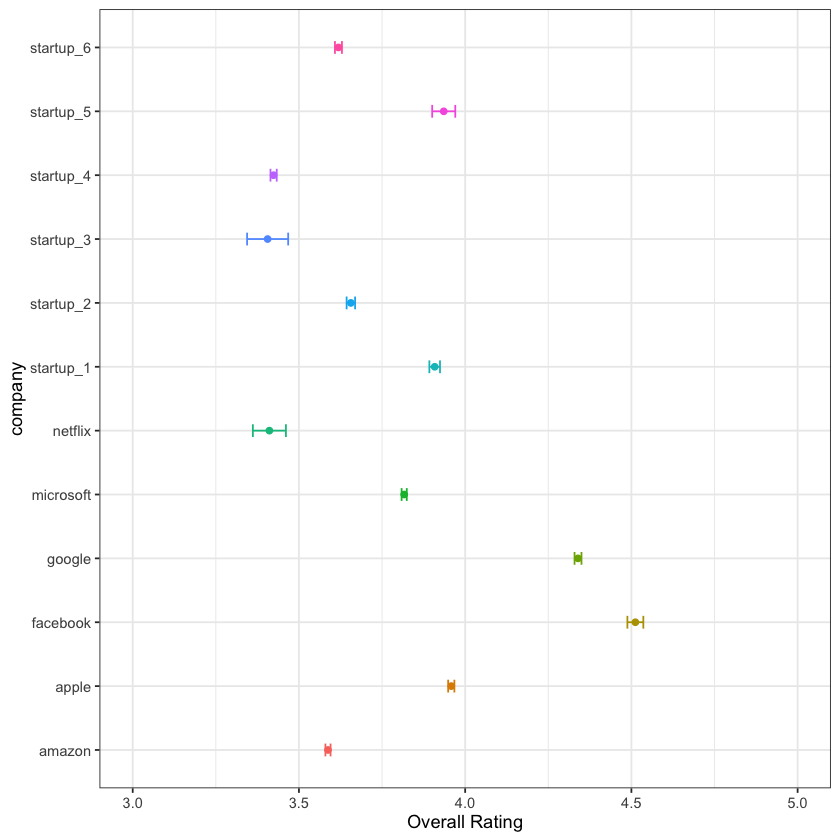

In [92]:
# Overall Rating of Each Company

overall_avgs %>%
  ggplot(aes(x=company,color=company,
             y=m,ymin=m-se,ymax=m+se)) +
  geom_point() +
  geom_errorbar(width=.2) +
  theme_bw() +
  coord_flip() + # coord_flip makes the axis labels readable!
  scale_y_continuous(limits = c(3,5)) +
  labs(y="Overall Rating")+
  theme(legend.position="none")

Warning message:
“Removed 2038 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 5258 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


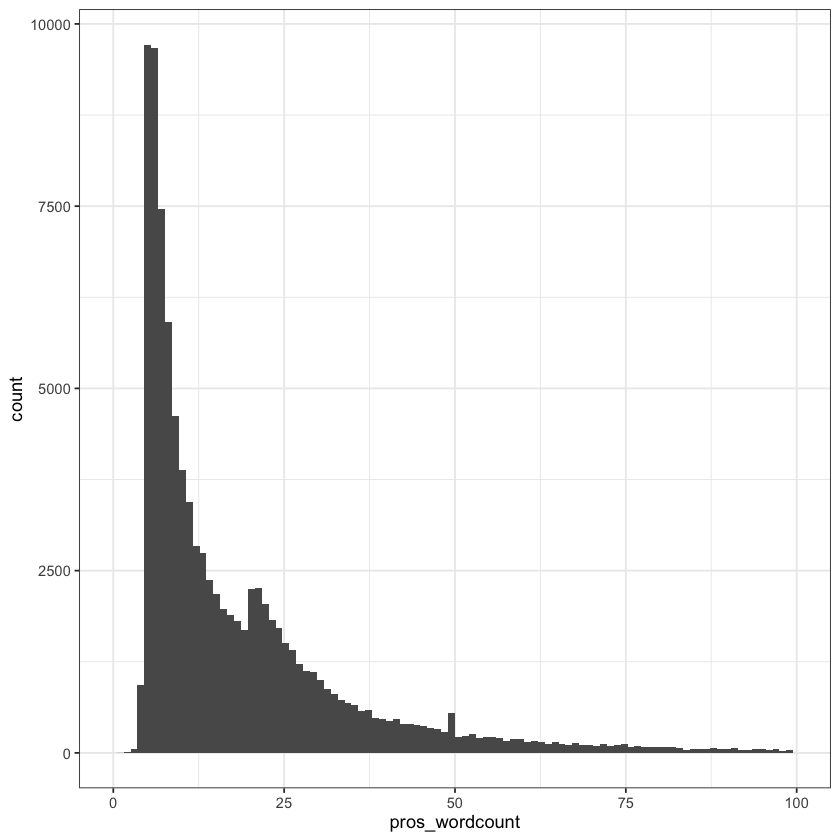

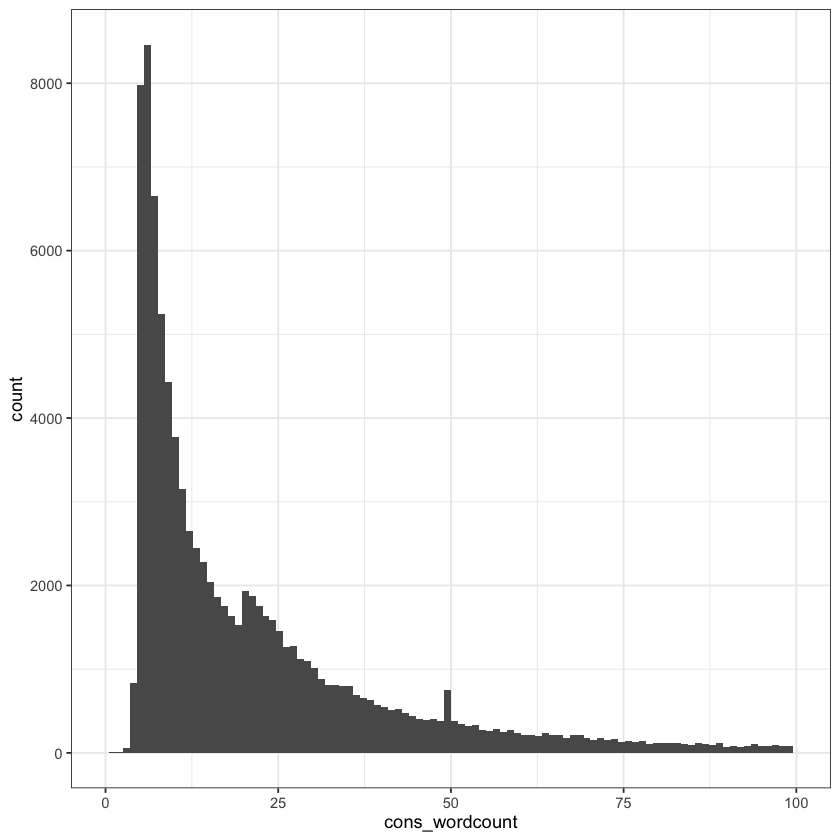

In [93]:
# Distribution of number of words in the dataset

# We segregate the histograms into pros and cons 
glassdoor <- glassdoor%>%
  mutate(pros_wordcount=str_count(pros,"[[:alpha:]]+"),
         cons_wordcount=str_count(cons,"[[:alpha:]]+"))

glassdoor %>%
  ggplot(aes(x=pros_wordcount)) +
  geom_histogram(bins = 100) +
  theme_bw() +
  xlim(0,100)

glassdoor %>%
  ggplot(aes(x=cons_wordcount)) +
  geom_histogram(bins = 100) +
  theme_bw() +
  xlim(0,100)

In [94]:
# Let's focus on people who actually wrote text in both boxes

gd_small<-glassdoor %>%
  filter(pros_wordcount>5 & cons_wordcount>5) # removes reviews that is less than 5 words

dim(gd_small)
# Even that's too big so let's get it down to 40,000 texts

# Before we randomise, use set.seed() to all get the same split
set.seed(0202) 

# Grab the first 40,000 rows after randomizing
gd_small<-gd_small %>%
  arrange(sample(1:n())) %>%
  slice(1:40000)

[1] 81116    19

In [95]:
# Split into train and test set
train_split=sample(1:nrow(gd_small),20000)

gd_train<-gd_small%>%
  slice(train_split)

gd_test<-gd_small%>%
  slice(-train_split)

## Question 1 - Why is the ngram model so much more accurate on the pros data than the cons data?

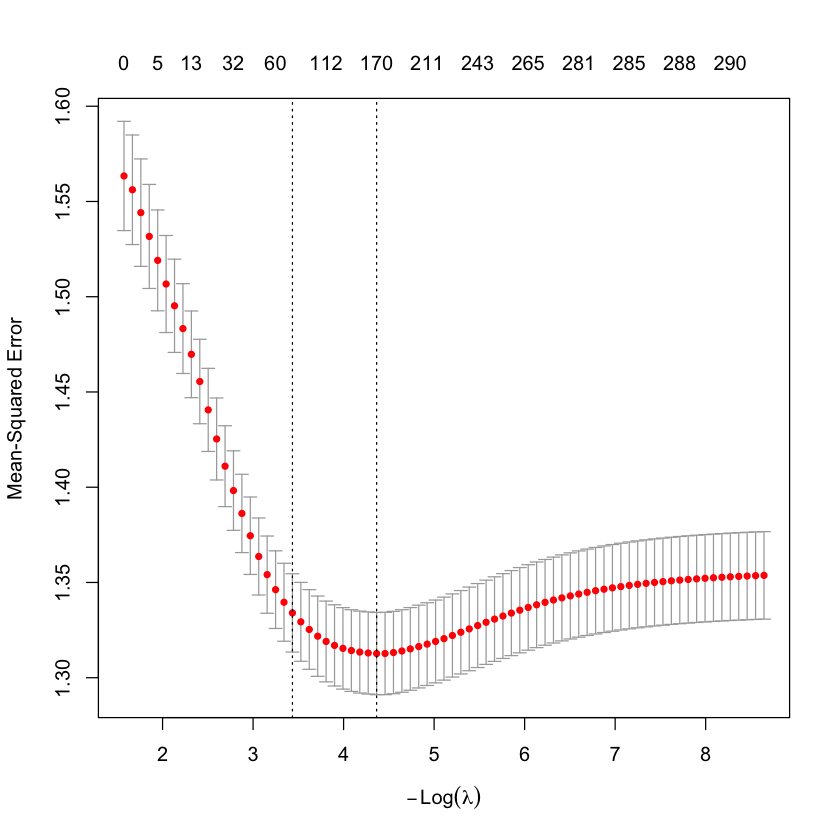

In [96]:
# Filtering for Amazon data

gd_amazon_train<-gd_train %>%
  filter(company=="amazon")

gd_amazon_test<-gd_test %>%
  filter(company=="amazon")

dfm_amazon_train_pros<-TMEF_dfm(gd_amazon_train$pros,ngrams=1:2) %>%
  convert(to="matrix")

amazon_train_Y<-gd_amazon_train %>%
  pull(overall)

# Put training data into LASSO model

amazon_model_pros<-cv.glmnet(x=dfm_amazon_train_pros,
                             y=amazon_train_Y)

# Check the tuning to see if there is useful information
plot(amazon_model_pros)


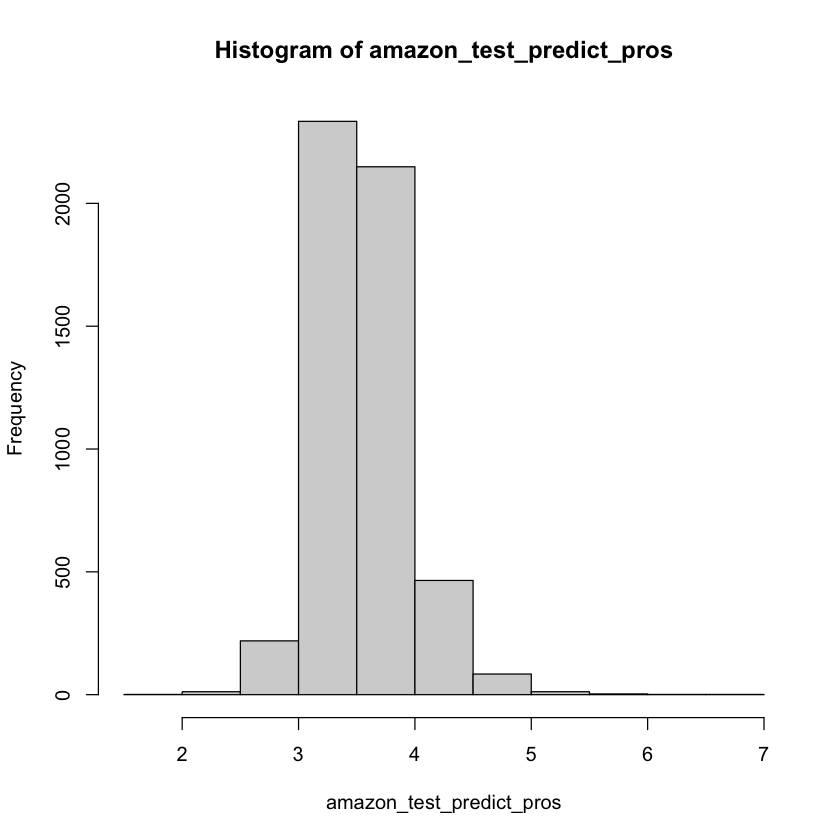

acc,lower,upper
<dbl>,<dbl>,<dbl>
65.26,63.97,66.54


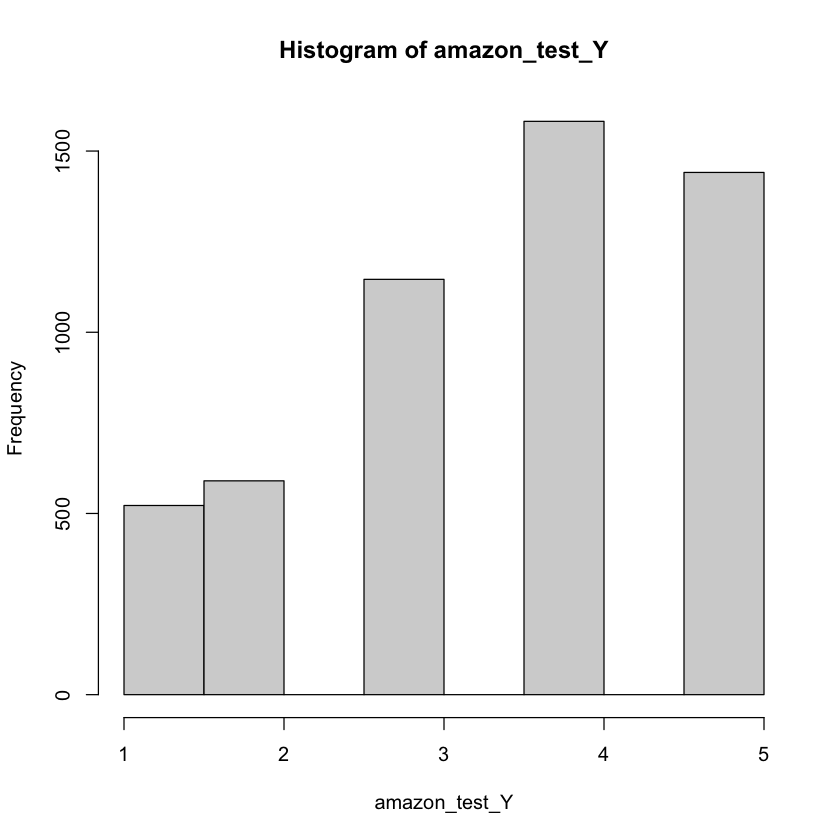

In [97]:
# Test the model on the pros text from amazon
dfm_amazon_test_pros<-TMEF_dfm(gd_amazon_test$pros,
                               ngrams=1:2,
                               min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>% # this matches the column names in the test and training set
  convert(to="matrix")

amazon_test_Y<-gd_amazon_test %>%
  pull(overall)

# Generate predictions for test data
amazon_test_predict_pros<-predict(amazon_model_pros,
                                  newx = dfm_amazon_test_pros)[,1]

# Check distributions - continuous predictor, continuous outcome
hist(amazon_test_predict_pros)
hist(amazon_test_Y)

# Estimate accuracy - use kendall's tau (the function that we created in a separate file)
pros_acc_1<-kendall_acc(amazon_test_predict_pros,amazon_test_Y)

pros_acc_1

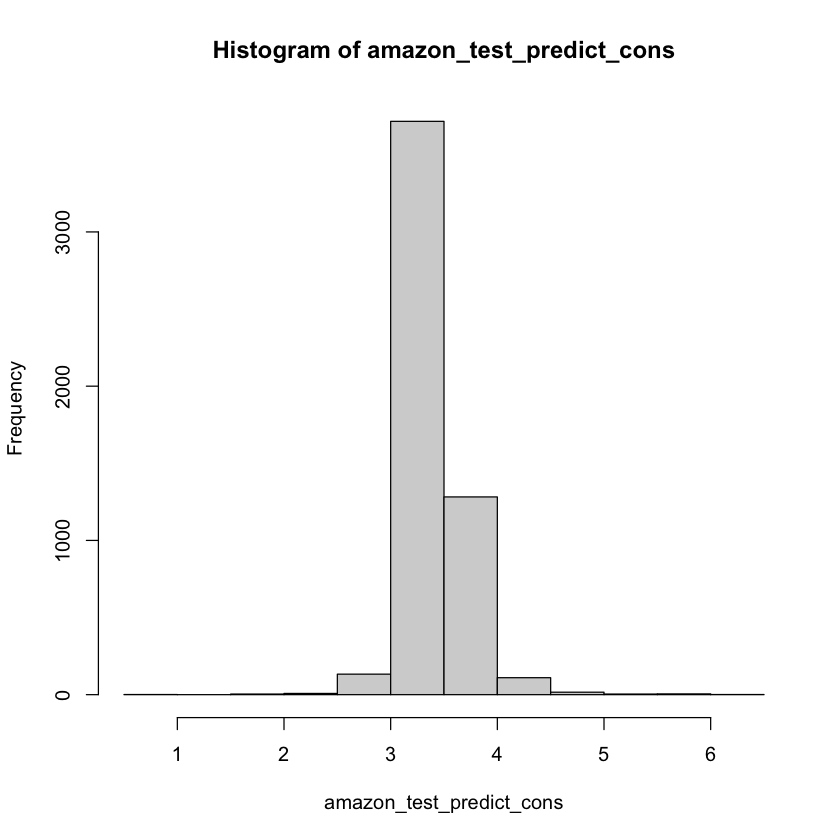

acc,lower,upper
<dbl>,<dbl>,<dbl>
47.45,46.11,48.8


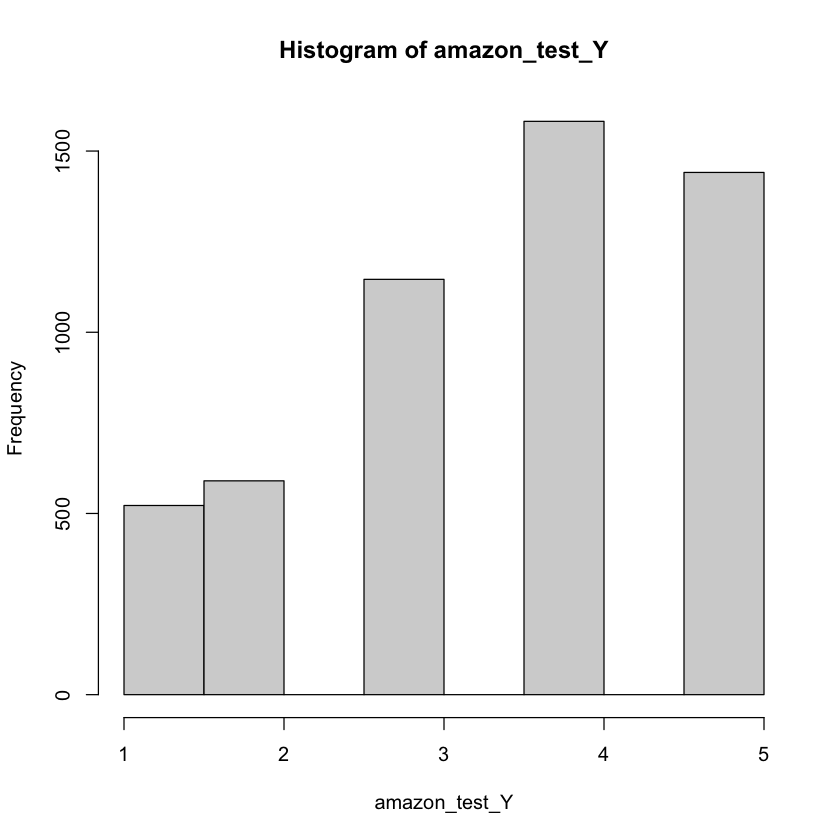

In [98]:
# Applying the same model to the cons text

dfm_amazon_test_cons<-TMEF_dfm(gd_amazon_test$cons,ngrams=1:2, min.prop=0)  %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>%
  convert(to="matrix")

# Generate predictions for test data
amazon_test_predict_cons<-predict(amazon_model_pros,
                                  newx = dfm_amazon_test_cons)[,1]

hist(amazon_test_predict_cons)
hist(amazon_test_Y)

# Estimate accuracy
cons_acc_1<-kendall_acc(amazon_test_predict_cons,amazon_test_Y)
cons_acc_1

## Question 2 - Model #2, training data on cons text from Amazon

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”


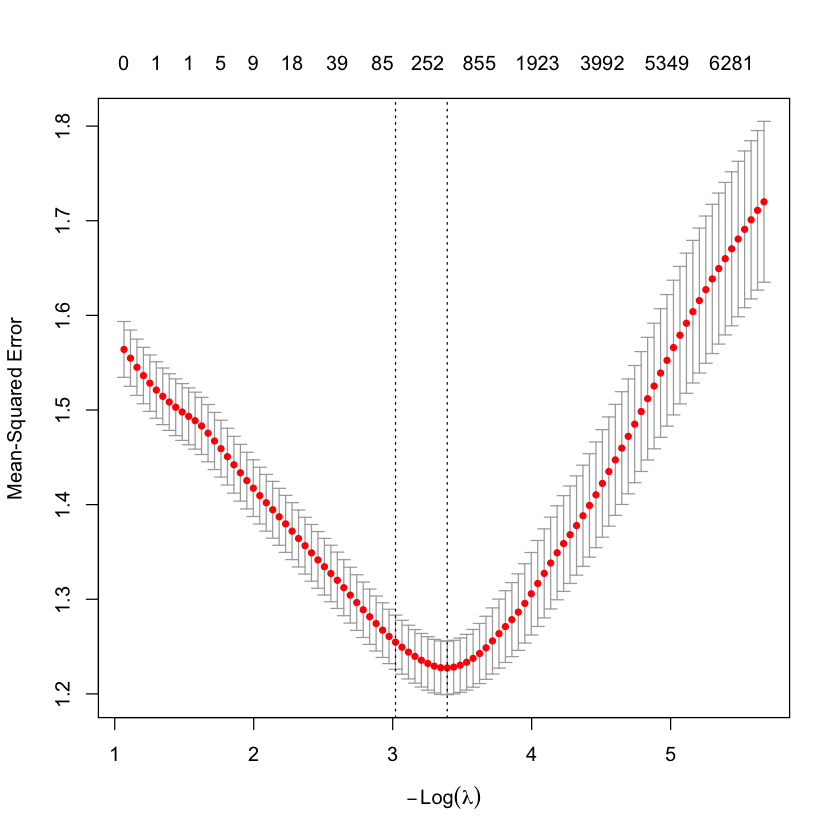

In [99]:
# Second Model - Trained on Cons Text

amazon_train_2 <- gd_train %>%
  filter(company == "amazon")

amazon_test_2 <- gd_test %>%
  filter(company == "amazon")

# DFM (cons)
dfm_amazon_train_cons <- TMEF_dfm(
  amazon_train_2$cons,
  ngrams = 1:2,
  min.prop = 0
) %>%
  convert(to = "matrix")

# Labels
amazon_train_Y <- amazon_train_2 %>% pull(overall)

# Fit LASSO
amazon_model_cons <- cv.glmnet(
  x = dfm_amazon_train_cons,
  y = amazon_train_Y
)

# Check tuning
plot(amazon_model_cons)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”


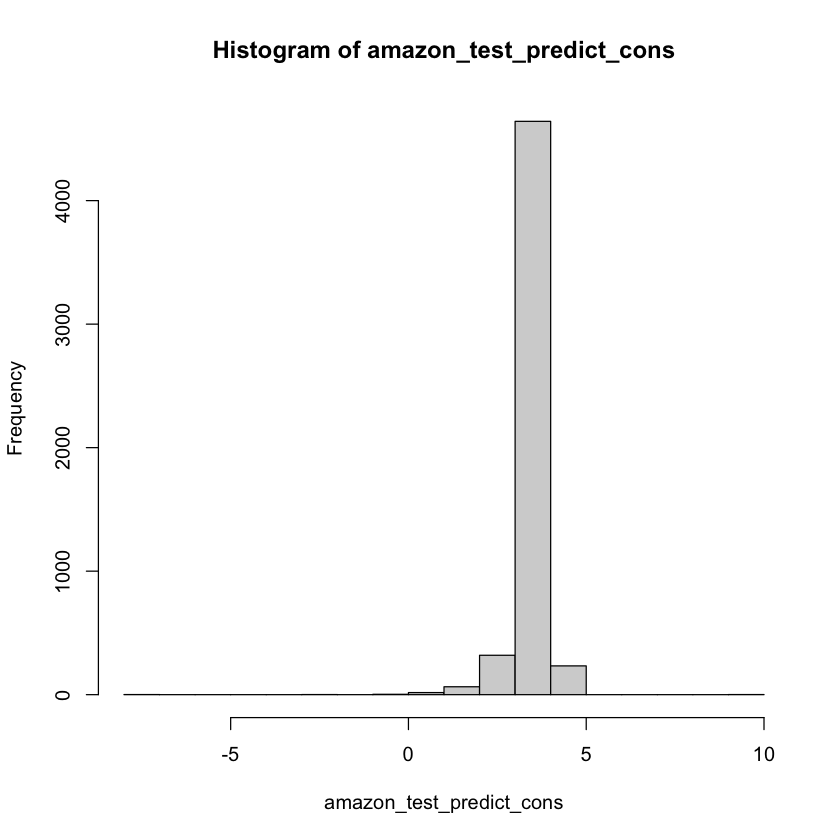

acc,lower,upper
<dbl>,<dbl>,<dbl>
70.46,69.23,71.69


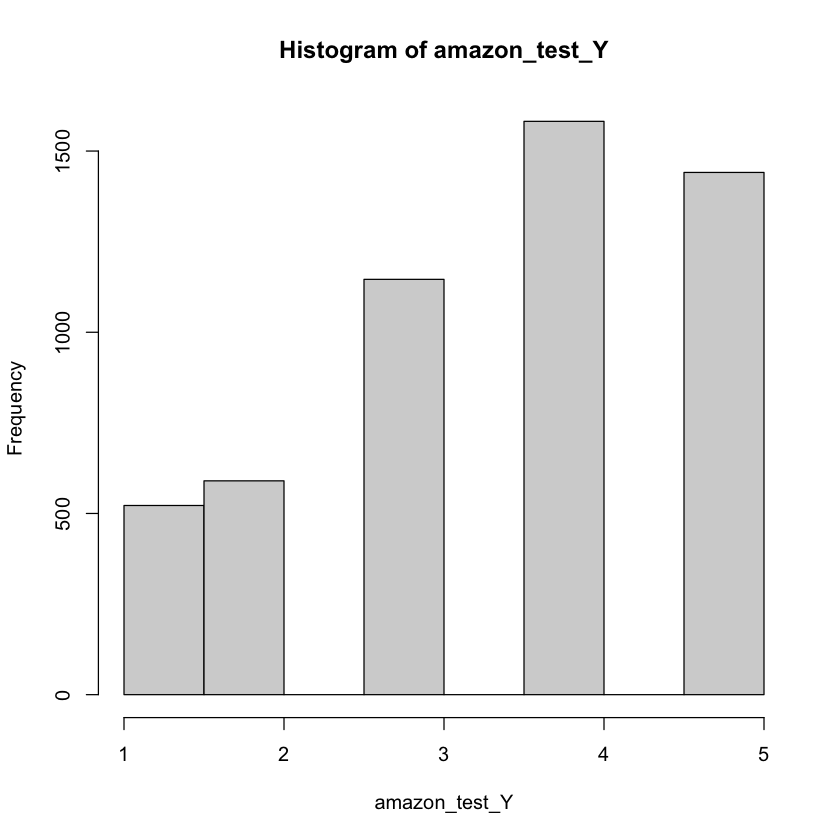

In [100]:
# Test the model on the pros text from amazon
dfm_amazon_test_cons <- TMEF_dfm(gd_amazon_test$cons,
                                ngrams = 1:2,
                                min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_cons)) %>%
  convert(to = "matrix")

# Generate predictions for test data
amazon_test_Y <- amazon_test_2 %>% 
  pull(overall)

# Predictions
amazon_test_predict_cons <- predict(amazon_model_cons,
                                    newx = dfm_amazon_test_cons)[, 1]


# Check distributions - continuous predictor, continuous outcome
hist(amazon_test_predict_cons)
hist(amazon_test_Y)

# Estimate accuracy 
pros_acc_2<-kendall_acc(amazon_test_predict_cons,amazon_test_Y)

pros_acc_2

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”


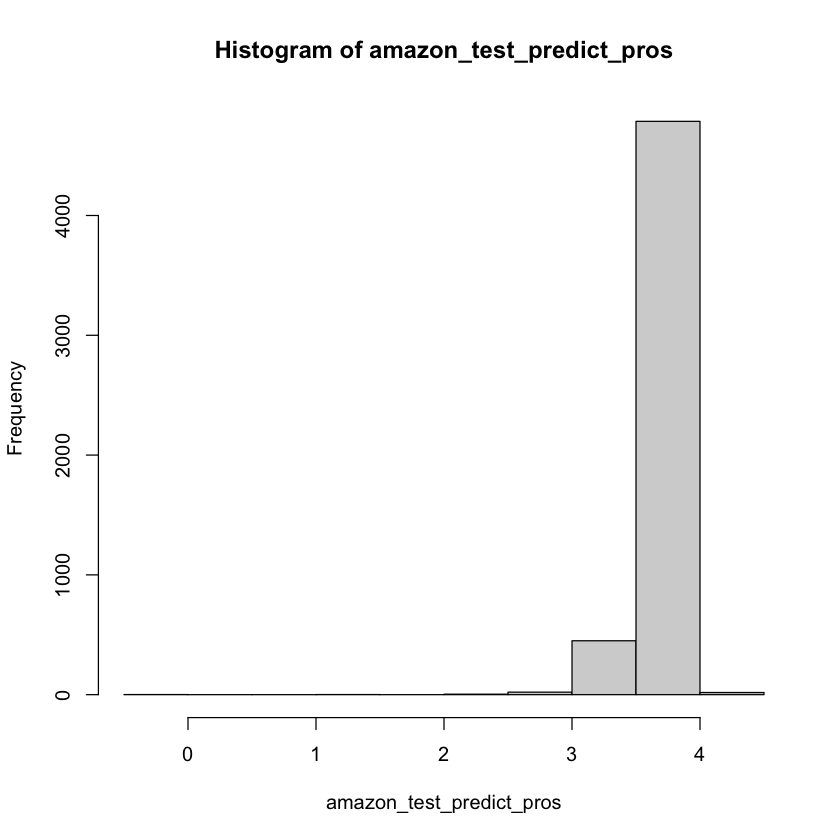

acc,lower,upper
<dbl>,<dbl>,<dbl>
48.32,46.97,49.67


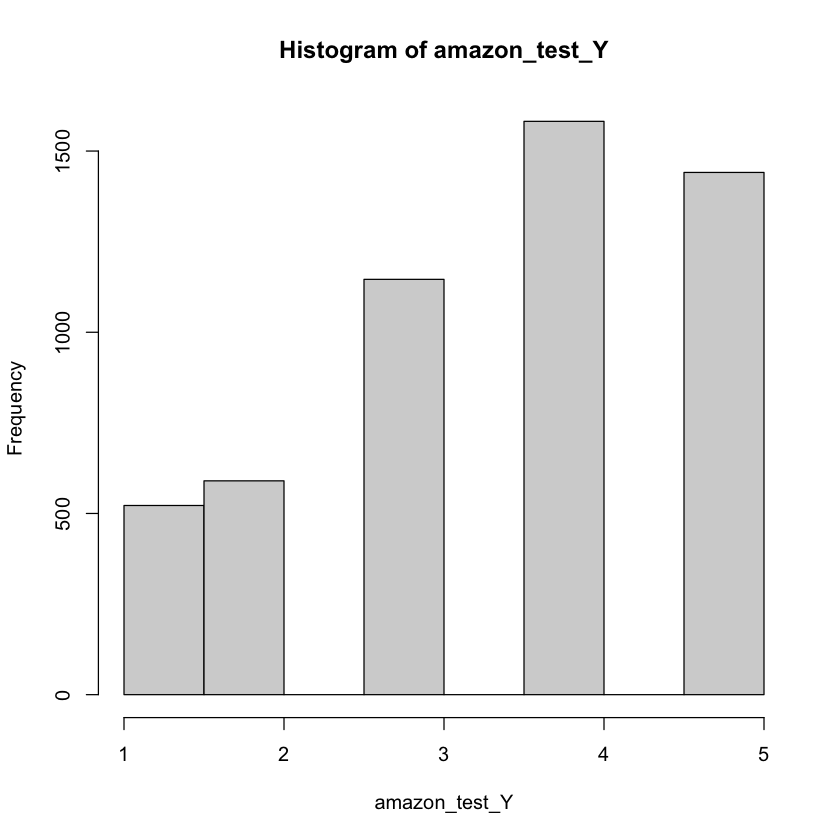

In [101]:
# Applying the same model to the pros text

dfm_amazon_test_pros<-TMEF_dfm(gd_amazon_test$pros,ngrams=1:2, min.prop=0)  %>%
  dfm_match(colnames(dfm_amazon_train_cons)) %>%
  convert(to="matrix")

# Generate predictions for test data
amazon_test_predict_pros<-predict(amazon_model_cons,
                                  newx = dfm_amazon_test_pros)[,1]

hist(amazon_test_predict_pros)
hist(amazon_test_Y)

# Estimate accuracy
cons_acc_2<-kendall_acc(amazon_test_predict_pros,amazon_test_Y)
cons_acc_2

## Question 3 - Accuracy Scores of each model

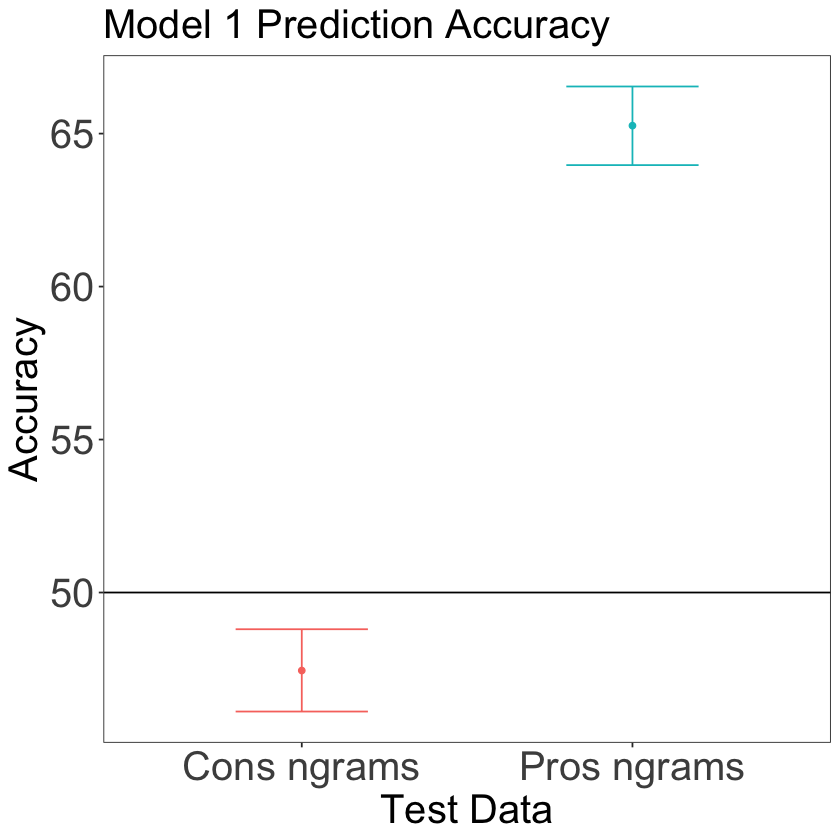

In [102]:
# Combine accuracy estimates for Model 1
bind_rows(pros_acc_1 %>%
            mutate(field="Pros ngrams"),
          cons_acc_1 %>%
            mutate(field="Cons ngrams")) %>%
  ggplot(aes(x=field,color=field,
             y=acc,ymin=lower,ymax=upper)) +
  geom_point() +
  geom_errorbar(width=.4) +
  theme_bw() +
  labs(x="Test Data",y="Accuracy", title="Model 1 Prediction Accuracy") +
  geom_hline(yintercept = 50) +
  theme(axis.text = element_text(size=24),
        axis.title = element_text(size=24),
        plot.title=element_text(size=24),
        panel.grid=element_blank(),
        legend.position="none")

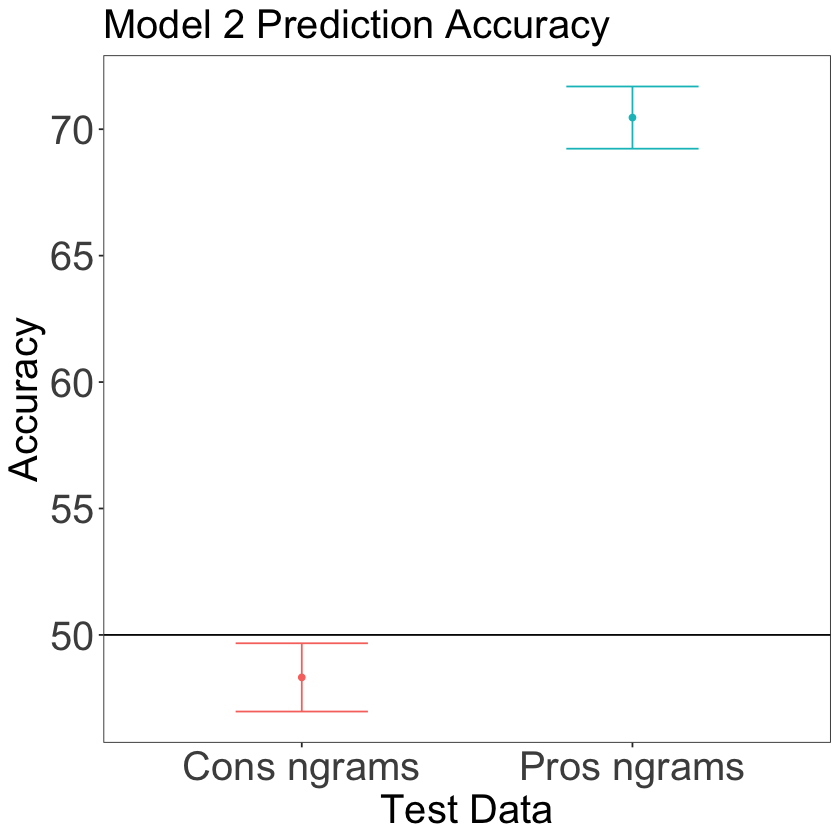

In [103]:
# Combine accuracy estimates for Model 2
bind_rows(pros_acc_2 %>%
            mutate(field="Pros ngrams"),
          cons_acc_2 %>%
            mutate(field="Cons ngrams")) %>%
  ggplot(aes(x=field,color=field,
             y=acc,ymin=lower,ymax=upper)) +
  geom_point() +
  geom_errorbar(width=.4) +
  theme_bw() +
  labs(x="Test Data",y="Accuracy", title="Model 2 Prediction Accuracy") +
  geom_hline(yintercept = 50) +
  theme(axis.text = element_text(size=24),
        axis.title = element_text(size=24),
        plot.title=element_text(size=24),
        panel.grid=element_blank(),
        legend.position="none")

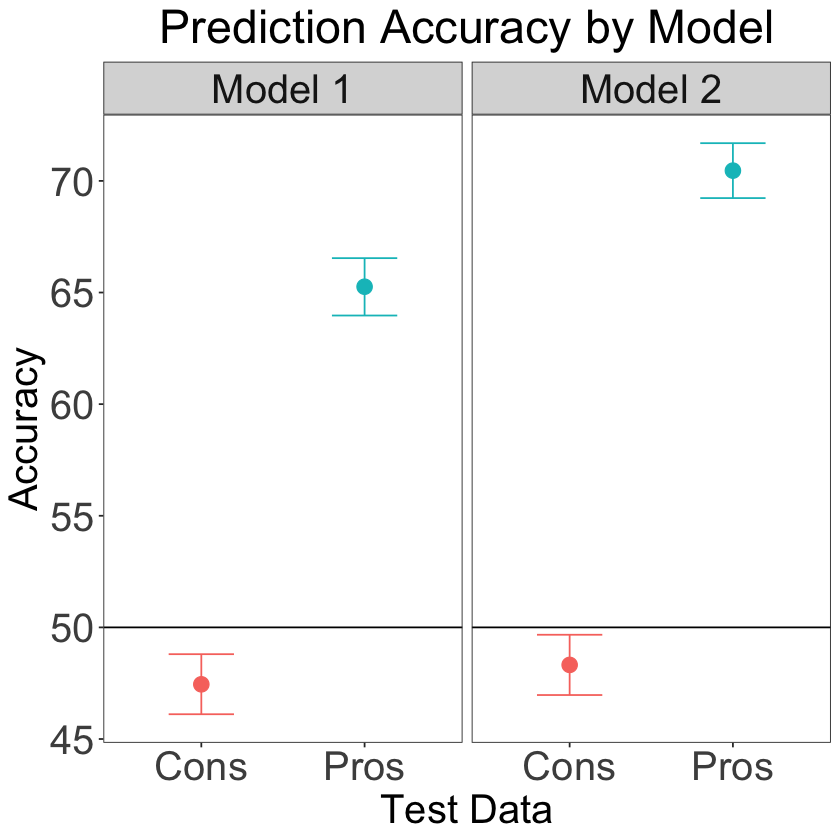

In [104]:
# Com
acc_all <- bind_rows(
  pros_acc_1 %>% mutate(field = "Pros", model = "Model 1"),
  cons_acc_1 %>% mutate(field = "Cons", model = "Model 1"),
  pros_acc_2 %>% mutate(field = "Pros", model = "Model 2"),
  cons_acc_2 %>% mutate(field = "Cons", model = "Model 2")
)

ggplot(acc_all,
       aes(x = field, color = field,
           y = acc, ymin = lower, ymax = upper)) +
  geom_point(size = 4) +
  geom_errorbar(width = .4) +
  geom_hline(yintercept = 50) +
  facet_wrap(~ model) +
  theme_bw() +
  labs(
    x = "Test Data",
    y = "Accuracy",
    title = "Prediction Accuracy by Model"
  ) +
  theme(
    axis.text = element_text(size = 24),
    axis.title = element_text(size = 24),
    plot.title = element_text(size = 28, hjust = 0.5),
    strip.text = element_text(size = 24),  
    panel.grid = element_blank(),
    legend.position = "none"
  )

# Looking at the accuracy plots side-by-side, we find that the second model (which was trained on con words) 
# was generally able to perform better in both pro and con test samples

## Question 4 - ngram coefficient plots 

### N-gram coefficient plot for Model 1

In [105]:
# Choose which lambda to use
s_used <- "lambda.1se"   # or "lambda.min"

# Extract coefficients
plotCoefs <- coef(amazon_model_pros, s = s_used) %>%
  as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("ngram")

# Rename coefficient column to "score"
names(plotCoefs)[names(plotCoefs) != "ngram"] <- "score"

# Keep non-zero (drop intercept)
plotCoefs <- plotCoefs %>%
  filter(
    ngram != "(Intercept)",
    !is.na(score),
    score != 0
  )

# Compute test frequencies (uses per document)
plotFreqs <- data.frame(
  ngram = colnames(dfm_amazon_test_pros),
  freq  = colMeans(dfm_amazon_test_pros)
)

# Combine
plotDat <- plotCoefs %>%
  inner_join(plotFreqs, by = "ngram") %>%
  mutate(across(c(score, freq), ~ round(., 3)))

head(plotDat)

,ngram,score,freq
,<chr>,<dbl>,<dbl>
1,learn,0.015,0.151
2,pros,-0.601,0.010
3,manag,0.018,0.117
4,place,0.032,0.094
5,work,0.065,0.624
6,opportun,0.171,0.159


Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_label_repel()`).”


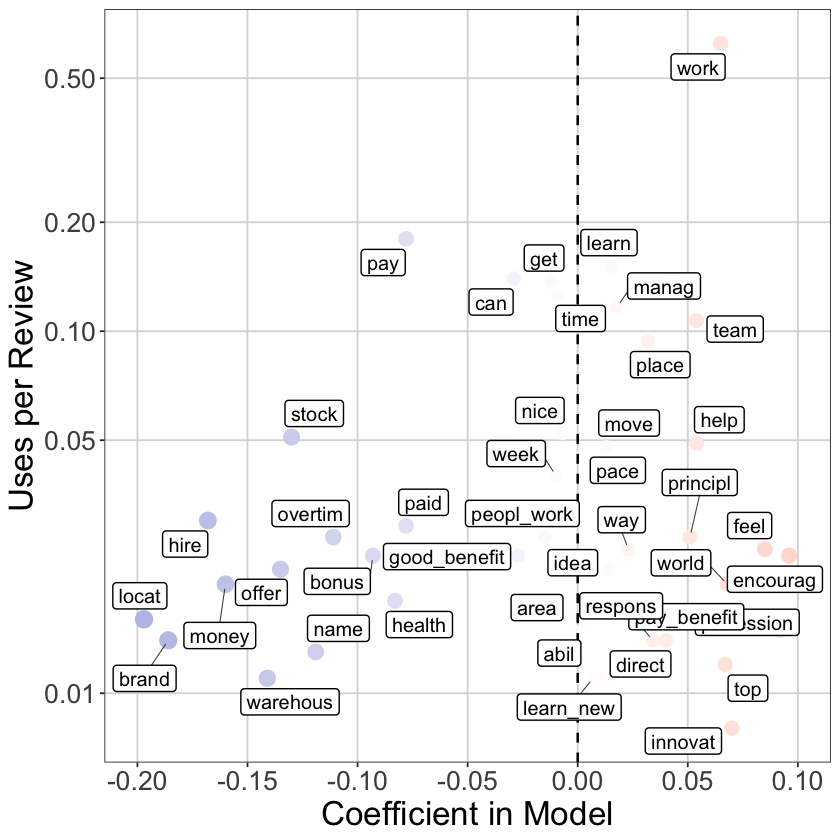

In [106]:
plotDat %>%
  ggplot(aes(x = score, y = freq)) +

  # points: keep colourful
  geom_point(aes(color = score, size = abs(score)),
             alpha = 1) +

  scale_color_gradient2(
    low  = "#0050B3",
    mid  = "white",
    high = "#D40000",
    midpoint = 0
  ) +
  scale_size_continuous(range = c(2.5, 6)) +
  guides(size = "none", color = "none") +

  geom_vline(xintercept = 0, linetype = "dashed", linewidth = 0.7) +

  # labels: force readable styling (no colour mapping, no transparency)
  ggrepel::geom_label_repel(
    aes(label = ngram),
    color = "black",        # text colour
    fill  = "white",        # label background
    alpha = 1,              # label opacity
    label.size = 0.4,       # border thickness
    size = 4.2,             # text size (try 4–5)
    box.padding = 0.35,
    point.padding = 0.25,
    segment.color = "grey30",
    segment.size = 0.3,
    max.overlaps = 15
  ) +

  scale_x_continuous(
    limits = c(-.2, .1),
    breaks = seq(-.2, .2, .05)
  ) +
  scale_y_continuous(
    trans = "log2",
    breaks = c(.01, .05, .1, .2, .5, 1, 2, 5)
  ) +

  theme_bw() +
  labs(x = "Coefficient in Model", y = "Uses per Review") +
  theme(
    axis.title = element_text(size = 20),
    axis.text  = element_text(size = 16),
    panel.grid.major = element_line(color = "grey85"),
    panel.grid.minor = element_blank()
  )


### N-gram coefficient plot for Model 2

In [107]:
# Extract non-zero coefficients from trained model
plotCoefs <- coef(amazon_model_cons, s = s_used) %>%
  as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("ngram")

# Rename the coefficient column robustly (whatever it's called) -> "score"
names(plotCoefs)[names(plotCoefs) != "ngram"] <- "score"

plotCoefs <- plotCoefs %>%
  filter(
    ngram != "(Intercept)",
    !is.na(score),
    score != 0
  )

# Compute test frequencies ("uses per review")
plotFreqs <- data.frame(
  ngram = colnames(dfm_amazon_test_cons),
  freq  = colMeans(dfm_amazon_test_cons)
)

# Combine + round
plotDat2 <- plotCoefs %>%
  inner_join(plotFreqs, by = "ngram") %>%   # only keep terms present in both (they should be)
  mutate(across(c(score, freq), ~ round(., 3)))

head(plotDat2)


,ngram,score,freq
,<chr>,<dbl>,<dbl>
1,unrealist,-0.299,0.009
2,break,-0.111,0.068
3,can,0.028,0.232
4,nobodi,-0.023,0.005
5,hour,-0.064,0.206
6,manag,-0.185,0.363


Warning message in scale_y_continuous(trans = "log2", breaks = c(0.01, 0.05, 0.1, :
“log-2 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log2", breaks = c(0.01, 0.05, 0.1, :
“log-2 transformation introduced infinite values.”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_label_repel()`).”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


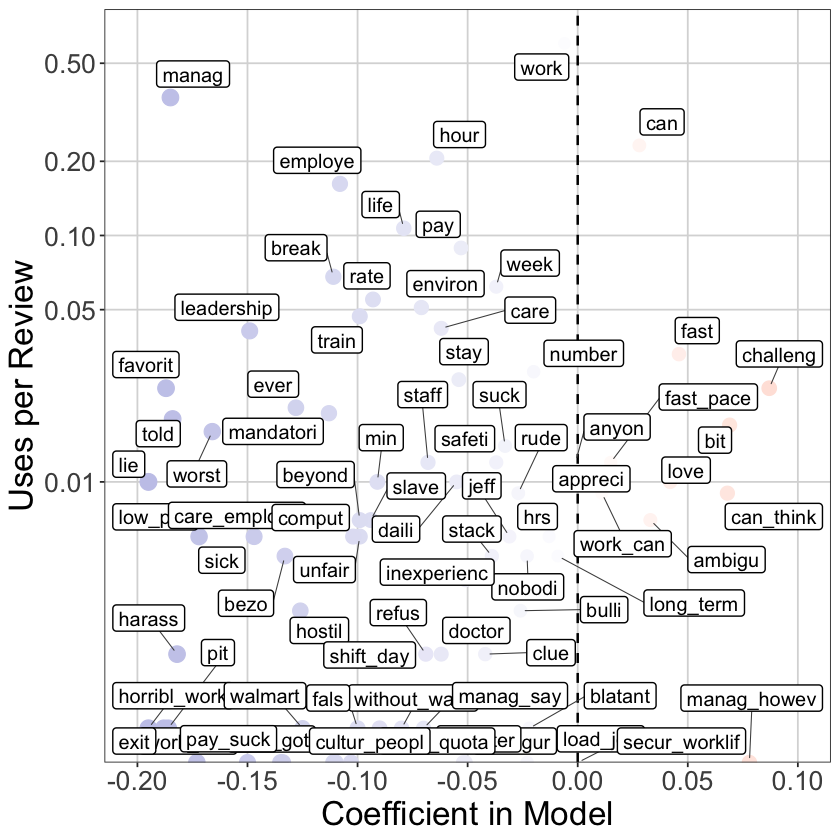

In [108]:
plotDat2 %>%
  ggplot(aes(x = score, y = freq)) +

  # points: keep colourful
  geom_point(aes(color = score, size = abs(score)),
             alpha = 1) +

  scale_color_gradient2(
    low  = "#0050B3",
    mid  = "white",
    high = "#D40000",
    midpoint = 0
  ) +
  scale_size_continuous(range = c(2.5, 6)) +
  guides(size = "none", color = "none") +

  geom_vline(xintercept = 0, linetype = "dashed", linewidth = 0.7) +

  # labels: force readable styling (no colour mapping, no transparency)
  ggrepel::geom_label_repel(
    aes(label = ngram),
    color = "black",        # text colour
    fill  = "white",        # label background
    alpha = 1,              # label opacity
    label.size = 0.4,       # border thickness
    size = 4.2,             # text size (try 4–5)
    box.padding = 0.35,
    point.padding = 0.25,
    segment.color = "grey30",
    segment.size = 0.3,
    max.overlaps = 15
  ) +

  scale_x_continuous(
    limits = c(-.2, .1),
    breaks = seq(-.2, .2, .05)
  ) +
  scale_y_continuous(
    trans = "log2",
    breaks = c(.01, .05, .1, .2, .5, 1, 2, 5)
  ) +

  theme_bw() +
  labs(x = "Coefficient in Model", y = "Uses per Review") +
  theme(
    axis.title = element_text(size = 20),
    axis.text  = element_text(size = 16),
    panel.grid.major = element_line(color = "grey85"),
    panel.grid.minor = element_blank()
  )


## Question 5 - Examples of text where the models get it wrong

In [109]:
gd_amazon_test <- gd_amazon_test %>%
  transmute(
    overall,
    pros = pros,
    cons = cons
  )
dfm_amazon_test_pros <- TMEF_dfm(gd_amazon_test$pros, ngrams = 1:2, min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>%
  convert(to = "matrix")

dfm_amazon_test_cons <- TMEF_dfm(gd_amazon_test$cons, ngrams = 1:2, min.prop = 0) %>%
  dfm_match(colnames(dfm_amazon_train_cons)) %>%
  convert(to = "matrix")

pred_pros_matched <- predict(amazon_model_pros, newx = dfm_amazon_test_pros)[, 1]
pred_cons_matched <- predict(amazon_model_cons, newx = dfm_amazon_test_cons)[, 1]


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”


In [110]:
# Construct Results Table
pros_results <- gd_amazon_test %>%
  mutate(
    model = "Pros model on pros text",
    text_type = "pros",
    text = pros,
    actual = overall,
    pred = pred_pros_matched,
    error = pred - actual,
    word_count = str_count(text, "[[:alpha:]]+")
  ) %>%
  filter(!is.na(text), word_count > 0, word_count <= 100)

cons_results <- gd_amazon_test %>%
  mutate(
    model = "Cons model on cons text",
    text_type = "cons",
    text = cons,
    actual = overall,
    pred = pred_cons_matched,
    error = pred - actual,
    word_count = str_count(text, "[[:alpha:]]+")
  ) %>%
  filter(!is.na(text), word_count > 0, word_count <= 100)


In [111]:
# Helper: pick one "pred high but actual low" and one "pred low but actual high" 
pick_two_examples <- function(df) {

  # Stars-based cutoffs
  hi_pred_lo_actual <- df %>%
    filter(actual <= 2, pred >= 4) %>%
    arrange(desc(error)) %>%
    slice(1)

  lo_pred_hi_actual <- df %>%
    filter(actual >= 4, pred <= 2) %>%
    arrange(error) %>%
    slice(1)

  # Fallbacks if those exact cutoffs don't exist:
  # Use "most overpredicted among low actual" and "most underpredicted among high actual"
  if (nrow(hi_pred_lo_actual) == 0) {
    hi_pred_lo_actual <- df %>%
      filter(actual <= 2) %>%
      arrange(desc(error)) %>%
      slice(1)
  }

  if (nrow(lo_pred_hi_actual) == 0) {
    lo_pred_hi_actual <- df %>%
      filter(actual >= 4) %>%
      arrange(error) %>%
      slice(1)
  }

  bind_rows(
    hi_pred_lo_actual %>% mutate(case = "Pred HIGH, actual LOW"),
    lo_pred_hi_actual %>% mutate(case = "Pred LOW, actual HIGH")
  )
}

In [112]:
# Get the four examples (2 from pros_results, 2 from cons_results) 
examples_4 <- bind_rows(
  pick_two_examples(pros_results),
  pick_two_examples(cons_results)
) %>%
  select(model, case, actual, pred, error, word_count, text)

examples_4

model,case,actual,pred,error,word_count,text
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Pros model on pros text,"Pred HIGH, actual LOW",1,4.842087,3.842087,98,Great place for someone fresh out of school with no work experience and no realization of what a real work environment is supposed to be like. Great minds are at Amazon. Meet them before they burn out and leave. Build your professional network. They have relatively good benefits. This is a great place to work if you’re one of those people that enjoy pushing your work off on others (also called “delegation”) and then claiming their success as your own. You will be recognized as a “leader” and be promoted despite your experience or lack of skills.
Pros model on pros text,"Pred LOW, actual HIGH",5,2.414969,-2.585031,82,"The starting pay rate was excellent and they approved overtime very frequently. There were numerous entry-level positions available, which allowed new hires to select from different areas of the warehouse. In addition, Amazon offered paid training and orientations alongside those hired through the outside firm were paid weekly instead of other variations. If you worked in outbound shipping and packaged customer's orders then every two hours employees would rotate with co-workers, which permitted individuals to do something else altogether."
Cons model on cons text,"Pred HIGH, actual LOW",1,4.228021,3.228021,10,There are no cons .High paid salary than other companies
Cons model on cons text,"Pred LOW, actual HIGH",5,2.525126,-2.474874,44,"I loved working there, they treat you like family, accepted my kids as part of their family and treat their employees amazingly. I would recommend this place to others in a heartbeat and would go back to working there if the opportunity presented itself."


The error analysis reveals clear limitations of modelling pros and cons text independently using a bag-of-ngrams approach. In several cases, the pros model substantially over-predicted low-rated reviews because it focused on locally positive phrases while missing broader context, contrast, or implicit criticism. Conversely, the model under-predicted genuinely high ratings when the pros text was neutral and descriptive rather than emotionally positive. Similar patterns appear in the cons model, where strong negative sentiment was sometimes underweighted, and positive reviews written in the cons field led to large under-predictions, indicating an over-reliance on word frequencies rather than semantic meaning. <br>

A natural improvement would be to combine pros and cons text into a single model or ensemble both predictions, reducing sensitivity to inconsistent reviewer behaviour. In addition, incorporating richer linguistic features, such as higher-order n-grams or explicit handling of negation and contrast—could help distinguish genuine sentiment from sarcasm or understatement. Finally, modelling the ordinal nature of star ratings or applying stronger regularisation may reduce extreme prediction errors when the textual signal is weak or ambiguous.

## Question 6 - Feature Engineering (Changing the pro-processing steps)

In [113]:
pros_train_text <- ifelse(is.na(gd_amazon_train$pros), "", as.character(gd_amazon_train$pros))
cons_train_text <- ifelse(is.na(gd_amazon_train$cons), "", as.character(gd_amazon_train$cons))

pros_test_text  <- ifelse(is.na(gd_amazon_test$pros),  "", as.character(gd_amazon_test$pros))
cons_test_text  <- ifelse(is.na(gd_amazon_test$cons),  "", as.character(gd_amazon_test$cons))

y_train <- gd_amazon_train$overall
y_test  <- gd_amazon_test$overall

In [114]:
# Changing Model 1
dfm_amazon_train_pros_new <- TMEF_dfm(
  pros_train_text,
  ngrams   = 2:2,      # BIGRAMS
  min.prop = 0,
  stem     = FALSE     # NO STEMMING
)
dfm_amazon_train_pros_new <- dfm_remove(dfm_amazon_train_pros_new, pattern = stopwords("en"))
x_train_pros_new <- convert(dfm_amazon_train_pros_new, to = "matrix")

amazon_model_pros_new <- cv.glmnet(x = x_train_pros_new, y = y_train, alpha = 1)

# Test DFM must match columns
dfm_amazon_test_pros_new <- TMEF_dfm(
  pros_test_text,
  ngrams   = 2:2,
  min.prop = 0,
  stem     = FALSE
) %>%
  dfm_remove(pattern = stopwords("en")) %>%
  dfm_match(colnames(x_train_pros_new)) %>%
  convert(to = "matrix")

pred_pros_new <- predict(amazon_model_pros_new, newx = dfm_amazon_test_pros_new, s = "lambda.1se")[,1]
pros_acc_new  <- kendall_acc(pred_pros_new, y_test)


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”


In [115]:
# Changing Model 2
dfm_amazon_train_cons_new <- TMEF_dfm(
  cons_train_text,
  ngrams   = 2:2,
  min.prop = 0,
  stem     = FALSE
)
dfm_amazon_train_cons_new <- dfm_remove(dfm_amazon_train_cons_new, pattern = stopwords("en"))
x_train_cons_new <- convert(dfm_amazon_train_cons_new, to = "matrix")

amazon_model_cons_new <- cv.glmnet(x = x_train_cons_new, y = y_train, alpha = 1)

dfm_amazon_test_cons_new <- TMEF_dfm(
  cons_test_text,
  ngrams   = 2:2,
  min.prop = 0,
  stem     = FALSE
) %>%
  dfm_remove(pattern = stopwords("en")) %>%
  dfm_match(colnames(x_train_cons_new)) %>%
  convert(to = "matrix")

pred_cons_new <- predict(amazon_model_cons_new, newx = dfm_amazon_test_cons_new, s = "lambda.1se")[,1]
cons_acc_new  <- kendall_acc(pred_cons_new, y_test)

pros_acc_new
cons_acc_new

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”


acc,lower,upper
<dbl>,<dbl>,<dbl>
62.1,60.79,63.41


acc,lower,upper
<dbl>,<dbl>,<dbl>
64.52,63.23,65.81


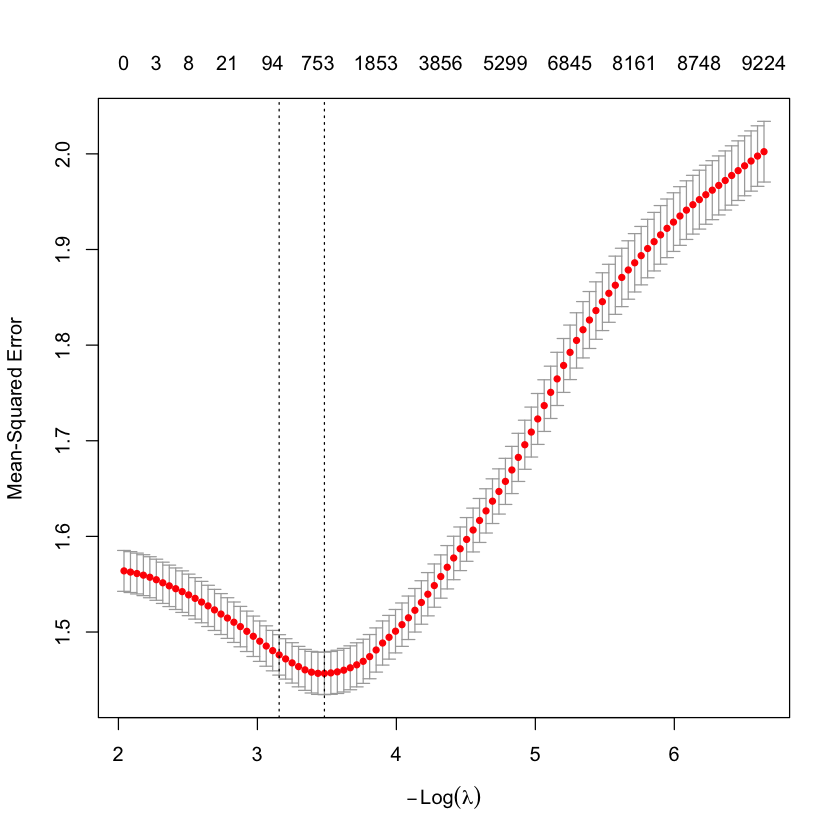

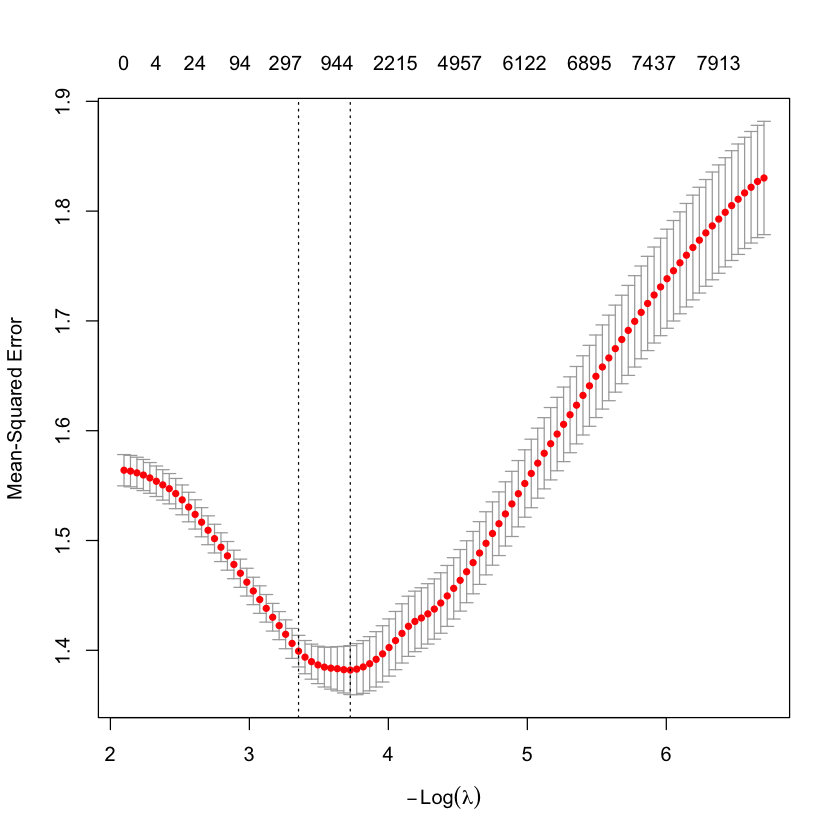

In [116]:
# Coefficient plots
plot(amazon_model_pros_new)
plot(amazon_model_cons_new)

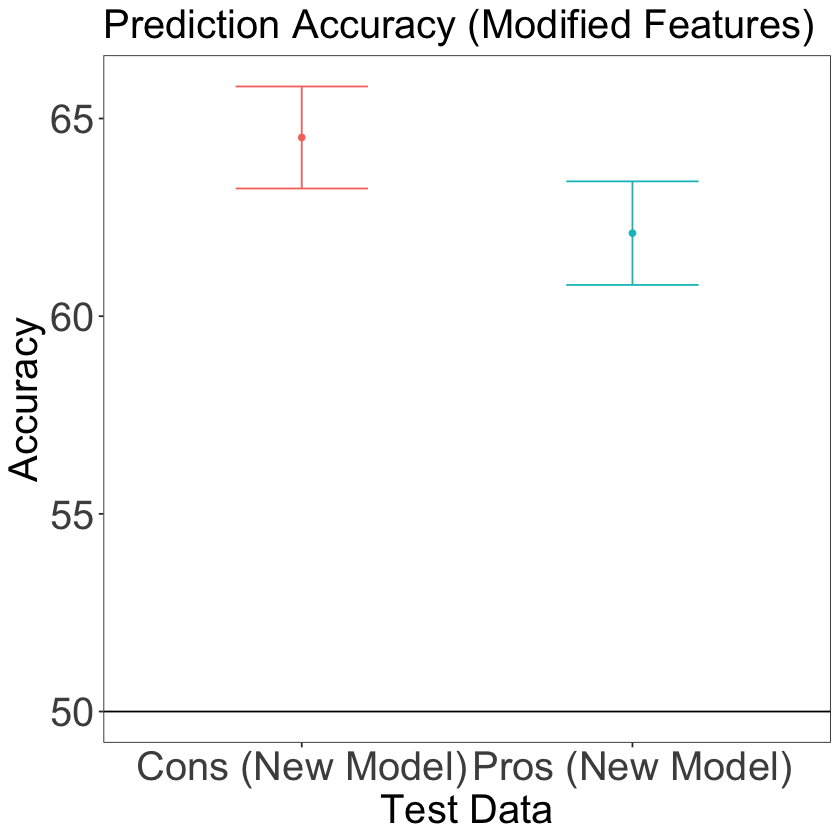

In [117]:
# Combine accuracy estimates for Q6 (your "changed" models)
acc_q6 <- bind_rows(
  pros_acc_new %>% mutate(field = "Pros (New Model)"),
  cons_acc_new %>% mutate(field = "Cons (New Model)")
)

# Plot with error bars 
ggplot(acc_q6, aes(x = field, y = acc, ymin = lower, ymax = upper, color = field)) +
  geom_point() +
  geom_errorbar(width = 0.4) +
  theme_bw() +
  labs(x = "Test Data", y = "Accuracy", title = "Prediction Accuracy (Modified Features)") +
  geom_hline(yintercept = 50) +
  theme(
    axis.text = element_text(size = 24),
    axis.title = element_text(size = 24),
    plot.title = element_text(size = 24),
    panel.grid = element_blank(),
    legend.position = "none"
  )

The new workflow follows the following set of rules:

- Uses bigrams only: ngrams = 2:2 - captures short context like “not good”, “good but”, “no support”
- Turn off stemming: stem = FALSE - this avoids collapsing meaningfully different word forms
- Remove stopwords using dfm_remove(... stopwords("en")) - helps to reduce noise from frequent function words
- Model matches test features to training using dfm_match(colnames(x_train_*_new))- ensures the test matrix has the exact same columns as training

## Question 7 - Transfer Learning 

### Using Amazon Data to Predict Star Ratings from Microsoft

In [118]:
# Transfer learning of Model 1 (Using Amazon pros on Microsoft pros)

# 1) Split by company
amazon_train <- gd_train %>% filter(company == "amazon")
microsoft_test <- gd_test %>% filter(company == "microsoft")

# 2) Build AMAZON training features (pros) + train model (if you already have this, skip training)
dfm_amazon_train_pros <- TMEF_dfm(
  ifelse(is.na(amazon_train$pros), "", as.character(amazon_train$pros)),
  ngrams = 1:2, min.prop = 0
) %>%
  convert(to = "matrix")

y_amazon <- amazon_train$overall

amazon_model_pros <- cv.glmnet(x = dfm_amazon_train_pros, y = y_amazon, alpha = 1)

# 3) Build MICROSOFT test features using the AMAZON vocabulary
dfm_ms_test_pros <- TMEF_dfm(
  ifelse(is.na(microsoft_test$pros), "", as.character(microsoft_test$pros)),
  ngrams = 1:2, min.prop = 0    
) %>%
  dfm_match(colnames(dfm_amazon_train_pros)) %>%   # <- transfer step
  convert(to = "matrix")

# 4) Predict on Microsoft + evaluate
pred_ms_from_amazon_pros <- predict(amazon_model_pros, newx = dfm_ms_test_pros, s = "lambda.1se")[,1]
y_ms <- microsoft_test$overall

ms_acc_from_amazon_pros <- kendall_acc(pred_ms_from_amazon_pros, y_ms)
ms_acc_from_amazon_pros

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


acc,lower,upper
<dbl>,<dbl>,<dbl>
58.5,56.91,60.08


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.045   3.429   3.585   3.630   3.786   6.163 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   3.778   5.000   5.000 

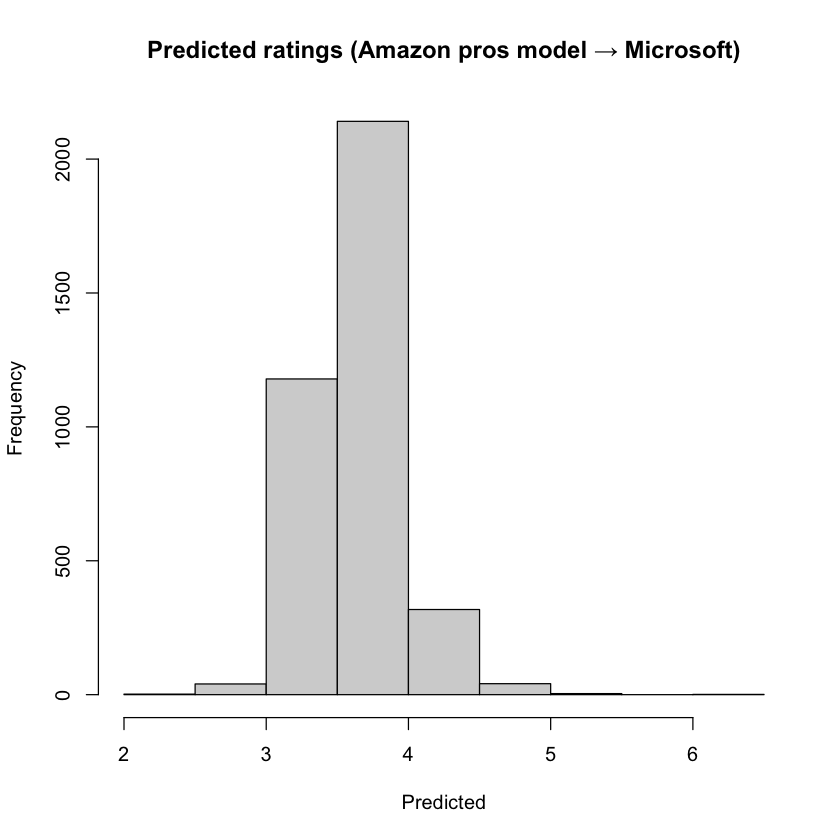

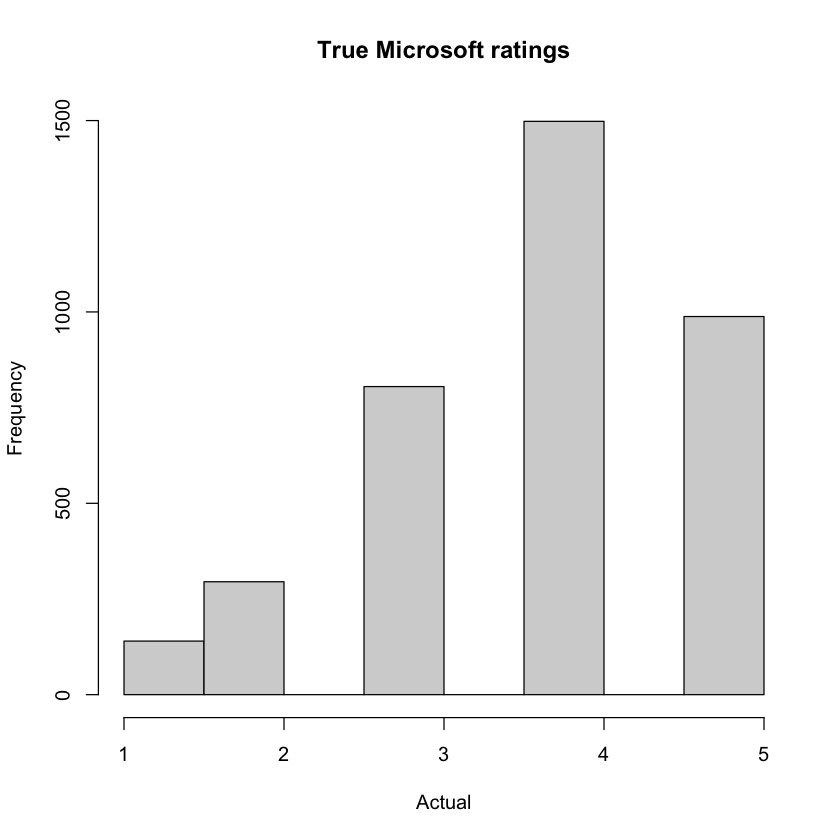

In [119]:
summary(pred_ms_from_amazon_pros)
summary(y_ms)

# base R histograms
hist(pred_ms_from_amazon_pros, main = "Predicted ratings (Amazon pros model → Microsoft)", xlab = "Predicted")
hist(y_ms, main = "True Microsoft ratings", xlab = "Actual")

### Training Model with Microsoft Data to Predict Star Ratings from Microsoft

In [ ]:
boot_kendall <- function(pred, y, B = 200, seed = 1) {
  set.seed(seed)
  pred <- as.numeric(pred)
  y    <- as.numeric(y)
  n <- length(y)

  vals <- replicate(B, {
    idx <- sample.int(n, n, replace = TRUE)

    p <- pred[idx]
    yy <- y[idx]

    ok <- is.finite(p) & is.finite(yy)
    p <- p[ok]; yy <- yy[ok]

    if (length(p) < 3 || sd(p) == 0 || sd(yy) == 0) return(NA_real_)

    cor(p, yy, method = "kendall", use = "complete.obs")
  })

  c(
    mean = mean(vals, na.rm = TRUE),
    se   = sd(vals, na.rm = TRUE)
  )
}

In [126]:
# Data splits
amazon_train <- gd_train %>% filter(company == "amazon")
ms_test      <- gd_test  %>% filter(company == "microsoft")
ms_train     <- gd_train %>% filter(company == "microsoft")

# Text + labels (pros)
x_amz_text <- ifelse(is.na(amazon_train$pros), "", as.character(amazon_train$pros))
y_amz      <- amazon_train$overall

x_ms_test_text <- ifelse(is.na(ms_test$pros), "", as.character(ms_test$pros))
y_ms_test      <- ms_test$overall

x_ms_train_text <- ifelse(is.na(ms_train$pros), "", as.character(ms_train$pros))
y_ms_train      <- ms_train$overall

# 2) Feature limit
K <- 5000

# 3) Train AMAZON pros model (top K features)
dfm_amz_tmp <- TMEF_dfm(x_amz_text, ngrams = 1:2, min.prop = 0)
keep_amz <- names(topfeatures(dfm_amz_tmp, K))

dfm_amz_train <- dfm_select(dfm_amz_tmp, pattern = keep_amz) %>%
  convert(to = "matrix")

amz_pros_model <- cv.glmnet(x = dfm_amz_train, y = y_amz, alpha = 1)

# Microsoft test in Amazon vocab (TRANSFER)
dfm_ms_test_in_amz_vocab <- TMEF_dfm(x_ms_test_text, ngrams = 1:2, min.prop = 0) %>%
  dfm_match(colnames(dfm_amz_train)) %>%
  convert(to = "matrix")

pred_ms_transfer <- predict(amz_pros_model, newx = dfm_ms_test_in_amz_vocab, s = "lambda.1se")[, 1]

# Train MICROSOFT pros model (top K features)
dfm_ms_tmp <- TMEF_dfm(x_ms_train_text, ngrams = 1:2, min.prop = 0)
keep_ms <- names(topfeatures(dfm_ms_tmp, K))

dfm_ms_train <- dfm_select(dfm_ms_tmp, pattern = keep_ms) %>%
  convert(to = "matrix")

ms_pros_model <- cv.glmnet(x = dfm_ms_train, y = y_ms_train, alpha = 1)

# Microsoft test in Microsoft vocab (IN-DOMAIN)
dfm_ms_test_in_ms_vocab <- TMEF_dfm(x_ms_test_text, ngrams = 1:2, min.prop = 0) %>%
  dfm_match(colnames(dfm_ms_train)) %>%
  convert(to = "matrix")

pred_ms_indomain <- predict(ms_pros_model, newx = dfm_ms_test_in_ms_vocab, s = "lambda.1se")[, 1]

# 5) Accuracy + error bars (bootstrap)
acc_transfer <- boot_kendall(pred_ms_transfer, y_ms_test, B = 200, seed = 1)
acc_indomain <- boot_kendall(pred_ms_indomain, y_ms_test, B = 200, seed = 2)

In [121]:
# Accuracy table from transfer learning
acc_plot_df <- tibble(
  test = c("Amazon model → Microsoft test", "Microsoft model → Microsoft test"),
  acc  = c(acc_transfer["mean"], acc_indomain["mean"]),
  se   = c(acc_transfer["se"],   acc_indomain["se"])
)

acc_plot_df

test,acc,se
<chr>,<dbl>,<dbl>
Amazon model → Microsoft test,NA,1.435924
Microsoft model → Microsoft test,NA,1.401801


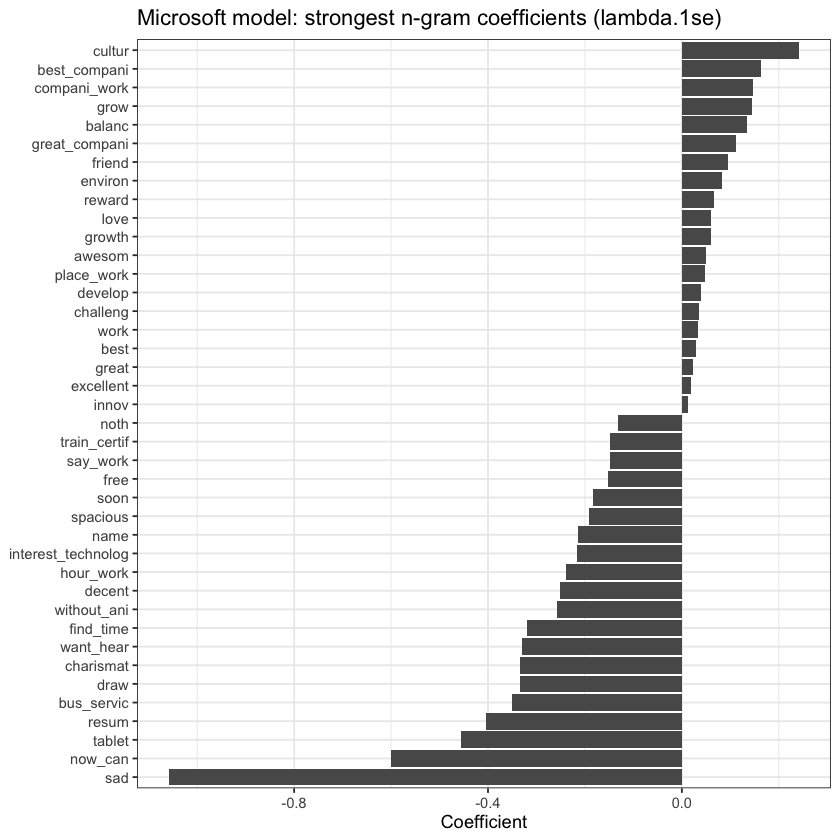

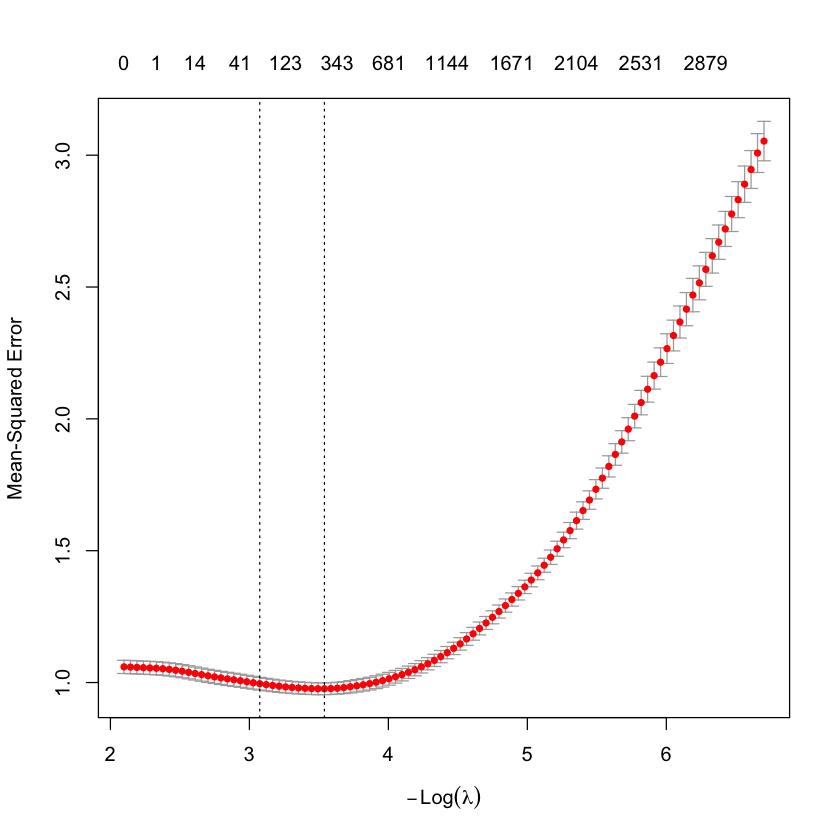

In [122]:
# Visualisations
s_used <- "lambda.1se"   # or "lambda.min"

# Extract coefficients
coef_df <- coef(ms_pros_model, s = s_used) %>%
  as.matrix() %>%
  as.data.frame() %>%
  rownames_to_column("ngram")

names(coef_df)[names(coef_df) != "ngram"] <- "coef"

coef_df <- coef_df %>%
  filter(ngram != "(Intercept)", coef != 0) %>%
  arrange(coef)

top_n <- 20

plot_df <- bind_rows(
  head(coef_df, top_n),  # most negative
  tail(coef_df, top_n)   # most positive
) %>%
  mutate(ngram = reorder(ngram, coef))

# Plot coefficients
ggplot(plot_df, aes(x = ngram, y = coef)) +
  geom_col() +
  coord_flip() +
  theme_bw() +
  labs(
    x = NULL,
    y = "Coefficient",
    title = paste0("Microsoft model: strongest n-gram coefficients (", s_used, ")")
  )

plot(ms_pros_model)